# Data Cleaning 

In [1]:
using Pkg;

# Installing packages
#Pkg.add("DelimitedFiles")
#Pkg.add("CSV")
#Pkg.add("DataFrames")
#Pkg.add("Pandas")
#Pkg.add("CategoricalArrays")
#Pkg.add("DataFramesMeta")
#Pkg.add("ScikitLearn")
#Pkg.add("GLM")
#Pkg.add("Plots")

In [129]:
using DelimitedFiles
using CSV
using Statistics 
using DataFramesMeta #using DataFrames
using CategoricalArrays;
include("./utils/preprocessing_utils.jl")
include("./utils/practices_code.jl")
using GLM
using Plots

In [3]:
data = CSV.File("./dataset/music_genre.csv") |> DataFrame;
first(data,10)

,Artist Name,Track Name,Popularity,danceability
,String,String,Float64?,Float64
1,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854
2,Boston,Hitch a Ride,54.0,0.382
3,The Raincoats,No Side to Fall In,35.0,0.434
4,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853
5,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167
6,The Stooges,Search and Destroy - Iggy Pop Mix,53.0,0.235
7,Solomon Burke,None Of Us Are Free,48.0,0.674
8,Randy Travis,On the Other Hand,55.0,0.657
9,Professional Murder Music,Slow,29.0,0.431


## Data Preprocessing

1. Set Data Types

In [34]:
df = copy(data);

df."key" = map((x) -> toString(x), df."key")
df."mode" = map((x) -> toString(x), df."mode")
df."time_signature" = map((x) -> toString(x), df."time_signature")
df."Class" = map((x) -> toString(x), df."Class")

categorical_columns = ["Artist Name","Track Name","key","mode","Class","time_signature"]

for category in categorical_columns
    df[:,category] = categorical(df[:,category]);
end

describe(df)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0
3,Popularity,44.5121,1.0,44.0,100.0,428
4,danceability,0.543433,0.0596,0.545,0.989,0
5,energy,0.662777,2.03e-5,0.7,1.0,0
6,key,,1.0,,9.0,2014
7,loudness,-7.91066,-39.952,-7.016,1.355,0
8,mode,,0,,1,0
9,speechiness,0.079707,0.0225,0.0474,0.955,0


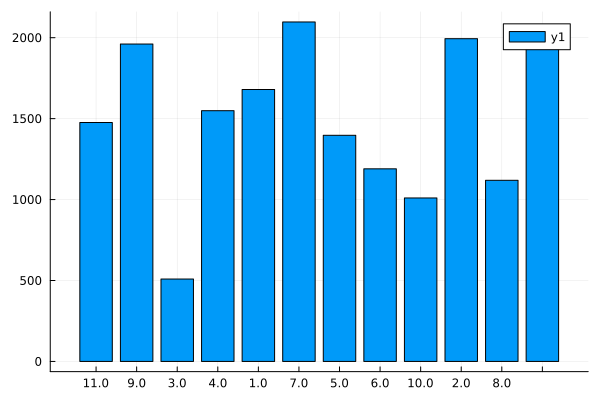

In [35]:
key_fdict,key_farray = pTable(df.key);
bar(key_farray[:,1],key_farray[:,2])

In [36]:

for colname in names(select(df, Not(categorical_columns)))
    noNa_column = skipmissing(df[:,colname])
    (sup_outlier,inf_outlier,ext_sup_outlier,ext_inf_outlier) = quartilOutliers(noNa_column)
    println("----",colname,"----")
    
    sup_outliers = findall(x-> x > sup_outlier, noNa_column)
    inf_outliers = findall(x-> x < inf_outlier, noNa_column)
    
    ext_sup_outliers = findall(x-> x > ext_sup_outlier, noNa_column)
    ext_inf_outliers = findall(x-> x < ext_inf_outlier, noNa_column)

    println("Outliers inf (x<",round(inf_outlier; digits=3),"):",length(inf_outliers)-length(ext_inf_outliers)," sup (x>",round(sup_outlier; digits=3),"):",length(sup_outliers)-length(ext_sup_outliers))
    println("Extreme outliers inf (x<",round(ext_inf_outlier; digits=3),"):",length(ext_inf_outliers)," sup (x>",round(ext_sup_outlier; digits=3),"):",length(ext_sup_outliers))

    if ((length(ext_inf_outliers)+length(ext_sup_outliers))>0)
        allowmissing!(df, colname);
        df[ext_sup_outliers,colname] .= missing
        df[ext_inf_outliers,colname] .= missing
        if (colname=="loudness")
            df[sup_outliers,colname] .= missing
            df[inf_outliers,colname] .= missing
        end
    end
end

----Popularity----
Outliers inf (x<-1.5):0 sup (x>90.5):41
Extreme outliers inf (x<-36.0):0 sup (x>125.0):0
----danceability----
Outliers inf (x<0.091):31 sup (x>1.0):0
Extreme outliers inf (x<-0.249):0 sup (x>1.34):0
----energy----
Outliers inf (x<-0.017):0 sup (x>1.386):0
Extreme outliers inf (x<-0.544):0 sup (x>1.913):0
----loudness----
Outliers inf (x<-16.062):634 sup (x>1.335):3
Extreme outliers inf (x<-22.585):181 sup (x>7.858):0
----speechiness----
Outliers inf (x<-0.038):0 sup (x>0.155):803
Extreme outliers inf (x<-0.11):0 sup (x>0.228):1231
----acousticness----
Outliers inf (x<-0.64):0 sup (x>1.079):0
Extreme outliers inf (x<-1.285):0 sup (x>1.723):0
----instrumentalness----
Outliers inf (x<-0.3):0 sup (x>0.5):1020
Extreme outliers inf (x<-0.6):0 sup (x>0.8):1388
----liveness----
Outliers inf (x<-0.143):0 sup (x>0.499):642
Extreme outliers inf (x<-0.384):0 sup (x>0.74):314
----valence----
Outliers inf (x<-0.266):0 sup (x>1.235):0
Extreme outliers inf (x<-0.828):0 sup (x>1.797)

In [37]:
describe(df)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0
3,Popularity,44.5121,1.0,44.0,100.0,428
4,danceability,0.543433,0.0596,0.545,0.989,0
5,energy,0.662777,2.03e-5,0.7,1.0,0
6,key,,1.0,,9.0,2014
7,loudness,-7.32448,-16.06,-6.855,0.943,818
8,mode,,0,,1,0
9,speechiness,0.0608453,0.0225,0.045,0.227,1231


### Quantity of missing values for each column

In [38]:
mvalues = describe(df,:nmissing,:eltype,:mean,:std,:min,:max)
mvalues.prop = mvalues.nmissing./sum(mvalues.nmissing)*100
mvalues = mvalues[mvalues.nmissing.>0,:]

,variable,nmissing,eltype,mean,std,min
,Symbol,Int64,Type,Union…,Union…,Any
1,Popularity,428,"Union{Missing, Float64}",44.5121,17.4269,1.0
2,key,2014,"Union{Missing, String}",,,1.0
3,loudness,818,"Union{Missing, Float64}",-7.32448,2.96732,-16.06
4,speechiness,1231,"Union{Missing, Float64}",0.0608453,0.0403151,0.0225
5,instrumentalness,5765,"Union{Missing, Float64}",0.0974663,0.199419,1.0e-6
6,liveness,314,"Union{Missing, Float64}",0.184099,0.131646,0.0119
7,duration_in min/ms,174,"Union{Missing, Float64}",1.96123e5,1.00199e5,0.50165


### Missing values Imputation

#### Correlation analysis

In [40]:
na_numeric_columns = map(x -> string(x),mvalues[:,"variable"])

deleteat!(na_numeric_columns, findall(x->x=="key",na_numeric_columns))

6-element Vector{String}:
 "Popularity"
 "loudness"
 "speechiness"
 "instrumentalness"
 "liveness"
 "duration_in min/ms"

In [41]:
na_numeric_columns = map(x -> string(x),mvalues[:,"variable"])

deleteat!(na_numeric_columns, findall(x->x=="key",na_numeric_columns))

df_numerical_columns = select(df[completecases(df),:], Not(categorical_columns))

table_names = append!(["col_name"],na_numeric_columns)

corr_matrix = DataFrame([ name =>[] for name in table_names])
for i in 1:size(df_numerical_columns,2)
    push!(corr_matrix,zeros(length(table_names)))
end

for (index,column) in enumerate(names(df_numerical_columns))
    corr_matrix[index,"col_name"] = column
    for sub_column in na_numeric_columns
        corr_value = cor(df_numerical_columns[:,sub_column],df_numerical_columns[:,column])
        if (abs(corr_value)>0.5)
            corr_matrix[index,sub_column] = corr_value
        end
    end
end

corr_matrix

,col_name,Popularity,loudness,speechiness,instrumentalness,liveness
,Any,Any,Any,Any,Any,Any
1,Popularity,1.0,0.0,0.0,0.0,0.0
2,danceability,0.0,0.0,0.0,0.0,0.0
3,energy,0.0,0.725534,0.0,0.0,0.0
4,loudness,0.0,1.0,0.0,0.0,0.0
5,speechiness,0.0,0.0,1.0,0.0,0.0
6,acousticness,0.0,-0.52682,0.0,0.0,0.0
7,instrumentalness,0.0,0.0,0.0,1.0,0.0
8,liveness,0.0,0.0,0.0,0.0,1.0
9,valence,0.0,0.0,0.0,0.0,0.0


As we see, the correlation matrix shows only two values greater than abs(0.5). We can use `energy` or `acousticness` or both to predict `loudness` using a linear regression. It is easy to know that the $R^2$ of the simple model of `energy` is going to be $$R^2=(r)^2=(0.7607)^2 \approx 0.579 \approx 58\%$$ 

Secondly we can try to train a linear regression with `energy` and `acousticness`:

In [42]:
# Linear Regresion

df_numerical_columns = select(df[completecases(df),:], Not(categorical_columns))
lmodel = lm(@formula(loudness  ~ energy+acousticness), df_numerical_columns)

print("R squared: ",r2(lmodel))

R squared: 0.527179575878898

In [43]:
# Linear Regresion

df_numerical_columns = select(df[completecases(df),:], Not(categorical_columns))
simple_model = lm(@formula(loudness  ~ energy), df_numerical_columns)

print("R squared: ",r2(simple_model))

R squared: 0.5264000613545823

With these results we can consider the simple model to replace the missing values of `loudness`

In [44]:
scatter(df[:,"energy"],df[:,"loudness"], title = "Scatter Plot Life Expectancy vs Adult Mortality Rate", ylabel = "Life Expectancy", xlabel = "Adult Mortality Rate",legend = false)

In [45]:
# Linear Regresion 

loudness = @select(df_numerical_columns, :loudness);
energy = @select(df_numerical_columns, :energy);
energy2 = @select(df_numerical_columns, :energy2 = :energy.^2);
energy3 = @select(df_numerical_columns, :energy3 = :energy.^3);

df_polyreg = hcat(loudness,energy,energy2,energy3)

poly_model = lm(@formula(loudness  ~ energy+energy2+energy3), df_polyreg)

println("R squared: ",r2(poly_model))
println(poly_model)


R squared: 0.5279810315043163
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

loudness ~ 1 + energy + energy2 + energy3

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -16.4102     0.334142  -49.11    <1e-99  -17.0652    -15.7552
energy        20.9411     1.91913    10.91    <1e-26   17.1792     24.703
energy2      -18.1936     3.40069    -5.35    <1e-07  -24.8596    -11.5275
energy3        9.47239    1.86991     5.07    <1e-06    5.80697    13.1378
──────────────────────────────────────────────────────────────────────────


In [46]:
for (index,row) in enumerate(completecases(df))
    if (row==false)
        df[index,"loudness"] = predLoudness(df[index,"energy"])
    end
end

In [47]:
describe(df)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0
3,Popularity,44.5121,1.0,44.0,100.0,428
4,danceability,0.543433,0.0596,0.545,0.989,0
5,energy,0.662777,2.03e-5,0.7,1.0,0
6,key,,1.0,,9.0,2014
7,loudness,-7.95594,-20.8163,-7.392,0.878,0
8,mode,,0,,1,0
9,speechiness,0.0608453,0.0225,0.045,0.227,1231


In [48]:
mvalues = describe(df,:nmissing,:eltype,:mean,:std,:min,:max)
mvalues.prop = mvalues.nmissing./sum(mvalues.nmissing)*100
mvalues = mvalues[mvalues.nmissing.>0,:]

,variable,nmissing,eltype,mean,std,min
,Symbol,Int64,Type,Union…,Union…,Any
1,Popularity,428,"Union{Missing, Float64}",44.5121,17.4269,1.0
2,key,2014,"Union{Missing, String}",,,1.0
3,speechiness,1231,"Union{Missing, Float64}",0.0608453,0.0403151,0.0225
4,instrumentalness,5765,"Union{Missing, Float64}",0.0974663,0.199419,1.0e-6
5,liveness,314,"Union{Missing, Float64}",0.184099,0.131646,0.0119
6,duration_in min/ms,174,"Union{Missing, Float64}",1.96123e5,1.00199e5,0.50165


In [49]:
using ScikitLearn
#@sk_import neighbors: KNeighborsClassifier
@sk_import neighbors: KNeighborsRegressor
@sk_import tree:DecisionTreeClassifier
using ScikitLearn.CrossValidation: cross_val_score

In [50]:
na_numeric_columns = map(x -> string(x),mvalues[:,"variable"])
deleteat!(na_numeric_columns, findall(x->x=="key",na_numeric_columns))

df_numerical_columns = select(df[completecases(df),:], Not(categorical_columns))
X = select(df_numerical_columns,Not(na_numeric_columns))

predictor_df = select(df,names(X))

for colname in na_numeric_columns
    y = select(df_numerical_columns,colname)
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(Matrix(X), Matrix(y))
    for (index,row) in enumerate(completecases(df))
        if (row==false)
            v = collect(predictor_df[index,:])
            v_matrix = permutedims(reshape(v, length(v), 1))
            df[index,colname] = model.predict(v_matrix)[1]
        end
    end
end

In [51]:
mvalues = describe(df,:nmissing,:eltype,:mean,:std,:min,:max)
mvalues.prop = mvalues.nmissing./sum(mvalues.nmissing)*100
mvalues = mvalues[mvalues.nmissing.>0,:]

,variable,nmissing,eltype,mean,std,min,max,prop
,Symbol,Int64,Type,Union…,Union…,Any,Any,Float64
1,key,2014,"Union{Missing, String}",,,1.0,9.0,100.0


In [52]:
describe(df)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0
3,Popularity,43.5492,1.0,43.0,98.0,0
4,danceability,0.543433,0.0596,0.545,0.989,0
5,energy,0.662777,2.03e-5,0.7,1.0,0
6,key,,1.0,,9.0,2014
7,loudness,-7.95594,-20.8163,-7.392,0.878,0
8,mode,,0,,1,0
9,speechiness,0.0589469,0.0225,0.04907,0.227,0


In [53]:
nona_df = df[completecases(df),:]

X = select(nona_df,Not(["key","Class","Artist Name","Track Name"]))
y = nona_df.key

tree = DecisionTreeClassifier(max_depth=4)
tree.fit(Matrix(X), reshape(y, 15982, 1))

predictor_df = select(df,names(X))

for (index,row) in enumerate(completecases(df))
    if (row==false)
        v = collect(predictor_df[index,:])
        v_matrix = permutedims(reshape(v, length(v), 1))
        df[index,"key"] = tree.predict(v_matrix)[1]
    end
end

In [54]:
describe(df)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,Artist Name,,$NOT,,◊†◊ê◊ì◊î,0
2,Track Name,,"""45""",,◊™◊™◊ó◊†◊†◊ô ◊ê◊ú◊ô◊ô,0
3,Popularity,43.5492,1.0,43.0,98.0,0
4,danceability,0.543433,0.0596,0.545,0.989,0
5,energy,0.662777,2.03e-5,0.7,1.0,0
6,key,,1.0,,9.0,0
7,loudness,-7.95594,-20.8163,-7.392,0.878,0
8,mode,,0,,1,0
9,speechiness,0.0589469,0.0225,0.04907,0.227,0


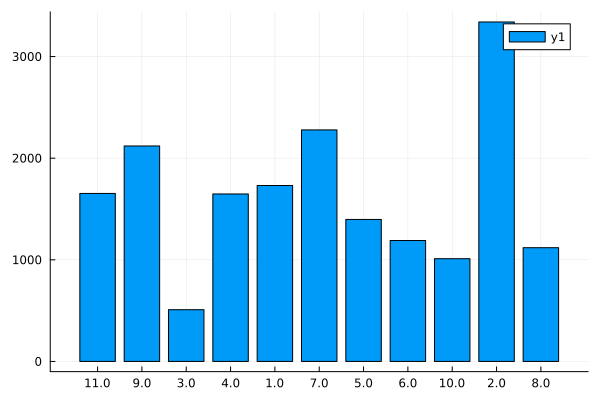

In [55]:
key_fdict,key_farray = pTable(df.key);
bar(key_farray[:,1],key_farray[:,2])

In [56]:
durationToSeconds(df."duration_in min/ms")
rename!(df,"duration_in min/ms" => "duration_seconds")

,Artist Name,Track Name
,String,String
1,Bruno Mars,That's What I Like (feat. Gucci Mane)
2,Boston,Hitch a Ride
3,The Raincoats,No Side to Fall In
4,Deno,Lingo (feat. J.I & Chunkz)
5,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered
6,The Stooges,Search and Destroy - Iggy Pop Mix
7,Solomon Burke,None Of Us Are Free
8,Randy Travis,On the Other Hand
9,Professional Murder Music,Slow


In [59]:
clean_df = copy(select(df,Not(["Artist Name","Track Name"])))

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness
,Float64?,Float64,Float64,String?,Float64?,String,Float64?,Float64
1,52.2,0.854,0.564,1.0,-8.6304,1,0.03404,0.0171
2,54.0,0.382,0.814,3.0,-7.23,1,0.0406,0.0011
3,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486
4,39.4,0.853,0.597,10.0,-8.32408,0,0.07602,0.0212
5,53.0,0.167,0.975,2.0,-4.279,1,0.216,0.000169
6,53.0,0.235,0.977,6.0,0.878,1,0.107,0.00353
7,48.0,0.674,0.658,5.0,-9.647,0,0.104,0.404
8,55.0,0.657,0.415,5.0,-9.915,1,0.025,0.175
9,29.0,0.431,0.776,10.0,-5.403,1,0.0527,2.21e-5


### Duplicate rows

In [60]:
clean_df = unique(clean_df)

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness
,Float64?,Float64,Float64,String?,Float64?,String,Float64?,Float64
1,52.2,0.854,0.564,1.0,-8.6304,1,0.03404,0.0171
2,54.0,0.382,0.814,3.0,-7.23,1,0.0406,0.0011
3,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486
4,39.4,0.853,0.597,10.0,-8.32408,0,0.07602,0.0212
5,53.0,0.167,0.975,2.0,-4.279,1,0.216,0.000169
6,53.0,0.235,0.977,6.0,0.878,1,0.107,0.00353
7,48.0,0.674,0.658,5.0,-9.647,0,0.104,0.404
8,55.0,0.657,0.415,5.0,-9.915,1,0.025,0.175
9,29.0,0.431,0.776,10.0,-5.403,1,0.0527,2.21e-5


In [144]:
class_fdict

Dict{Any, Any} with 11 entries:
  "4"  => 387
  "1"  => 1369
  "2"  => 1267
  "6"  => 2584
  "5"  => 1445
  "7"  => 575
  "8"  => 1849
  "10" => 4913
  "0"  => 625
  "9"  => 2507
  "3"  => 402

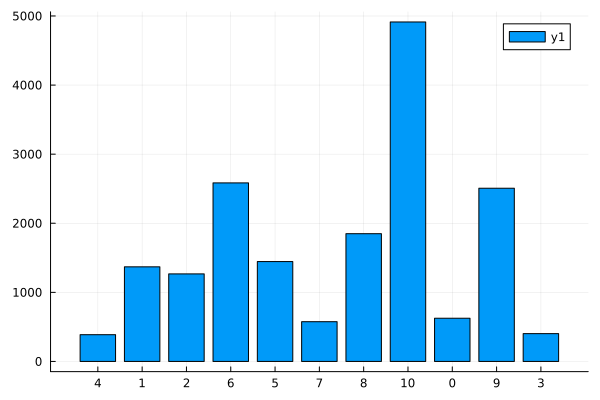

In [143]:
levels(clean_df.Class)
class_fdict,class_farray = pTable(clean_df.Class);
bar(class_farray[:,1],class_farray[:,2])

In [155]:
for (index,value) in enumerate(clean_df.Class)
    if (value == "0" || value == "7" || value == "3" || value == "4")
        clean_df[index,"Class"] = "Other"
    end
end

In [156]:
levels(clean_df.Class)
class_fdict,class_farray = pTable(clean_df.Class);
class_fdict

Dict{Any, Any} with 8 entries:
  "1"     => 1369
  "Other" => 1989
  "5"     => 1445
  "10"    => 4913
  "6"     => 2584
  "2"     => 1267
  "9"     => 2507
  "8"     => 1849

In [140]:
numeric_clean_df = copy(clean_df)

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness
,Float64?,Float64,Float64,String?,Float64?,String,Float64?,Float64
1,52.2,0.854,0.564,1.0,-8.6304,1,0.03404,0.0171
2,54.0,0.382,0.814,3.0,-7.23,1,0.0406,0.0011
3,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486
4,39.4,0.853,0.597,10.0,-8.32408,0,0.07602,0.0212
5,53.0,0.167,0.975,2.0,-4.279,1,0.216,0.000169
6,53.0,0.235,0.977,6.0,0.878,1,0.107,0.00353
7,48.0,0.674,0.658,5.0,-9.647,0,0.104,0.404
8,55.0,0.657,0.415,5.0,-9.915,1,0.025,0.175
9,29.0,0.431,0.776,10.0,-5.403,1,0.0527,2.21e-5


In [141]:
describe(numeric_clean_df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Popularity,43.5422,1.0,43.0,98.0,0,"Union{Missing, Float64}"
2,danceability,0.543478,0.0596,0.545,0.989,0,Float64
3,energy,0.662732,2.03e-5,0.7,1.0,0,Float64
4,key,,1.0,,9.0,0,"Union{Missing, String}"
5,loudness,-7.95533,-20.8163,-7.39,0.878,0,"Union{Missing, Float64}"
6,mode,,0,,1,0,String
7,speechiness,0.0589591,0.0225,0.04906,0.227,0,"Union{Missing, Float64}"
8,acousticness,0.247057,0.0,0.0813,0.996,0,Float64
9,instrumentalness,0.102308,1.0e-6,0.0163,0.799,0,"Union{Missing, Float64}"


In [137]:
numeric_clean_df = hcat(numeric_clean_df,categoricalToNumericDataFrame(numeric_clean_df.key,"key"))
numeric_clean_df

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness
,Float64?,Float64,Float64,String?,Float64?,String,Float64?,Float64
1,52.2,0.854,0.564,1.0,-8.6304,1,0.03404,0.0171
2,54.0,0.382,0.814,3.0,-7.23,1,0.0406,0.0011
3,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486
4,39.4,0.853,0.597,10.0,-8.32408,0,0.07602,0.0212
5,53.0,0.167,0.975,2.0,-4.279,1,0.216,0.000169
6,53.0,0.235,0.977,6.0,0.878,1,0.107,0.00353
7,48.0,0.674,0.658,5.0,-9.647,0,0.104,0.404
8,55.0,0.657,0.415,5.0,-9.915,1,0.025,0.175
9,29.0,0.431,0.776,10.0,-5.403,1,0.0527,2.21e-5


In [157]:
CSV.write("./dataset/clean_music_genre.csv",clean_df)

"./dataset/clean_music_genre.csv"

In [71]:
using ScikitLearn
@sk_import feature_selection:(SelectKBest,chi2)

PyObject <function chi2 at 0x00000000AD4D0790>

In [69]:
X = select(clean_df,Not("Class"))
y = clean_df.Class;

In [76]:
Matrix(X)

17923×14 Matrix{Any}:
 52.2  0.854  0.564   "1.0"    -8.6304   …  0.899   134.071  234.596  "4"
 54.0  0.382  0.814   "3.0"    -7.23        0.569   116.454  251.733  "4"
 35.0  0.434  0.614   "6.0"    -8.334       0.787   147.681  109.667  "4"
 39.4  0.853  0.597   "10.0"   -8.32408     0.569   107.033  173.968  "4"
 53.0  0.167  0.975   "2.0"    -4.279       0.0918  199.06   229.96   "4"
 53.0  0.235  0.977   "6.0"     0.878    …  0.241   152.952  208.133  "4"
 48.0  0.674  0.658   "5.0"    -9.647       0.677   143.292  329.387  "4"
 55.0  0.657  0.415   "5.0"    -9.915       0.347    96.03   186.347  "4"
 29.0  0.431  0.776   "10.0"   -5.403       0.318   120.857  237.867  "4"
 49.4  0.716  0.885   "1.0"    -5.61093     0.833   128.043  164.093  "4"
 11.0  0.491  0.563   "7.0"    -8.588    …  0.843    95.558  259.827  "4"
 43.6  0.387  0.922   "9.0"    -5.15467     0.417   146.478  222.947  "4"
 30.6  0.585  0.381   "1.0"   -10.7865      0.322   143.876  206.875  "4"
  ⋮             

In [77]:
chi2_selector = SelectKBest(chi2, k=2)
X_kbest = chi2_selector.fit_transform(Matrix(X), y)
print(X_kbest)

LoadError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\mhorm\.julia\packages\PyCall\ygXW2\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError("dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.")
  File "C:\Users\mhorm\.julia\conda\3\lib\site-packages\sklearn\base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\mhorm\.julia\conda\3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py", line 461, in fit
    X, y = self._validate_data(
  File "C:\Users\mhorm\.julia\conda\3\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mhorm\.julia\conda\3\lib\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "C:\Users\mhorm\.julia\conda\3\lib\site-packages\sklearn\utils\validation.py", line 887, in check_array
    raise ValueError(
